# Regular machine learning algorithm design workflow:

1. Setup problem parametrically
2. Define cost function
3. Obtain gradient
4. Minimize cost


## Machine learning example task
Predict house value using house area. This is a **regression** problem, the var to predict $\in \mathbb{R}^n$

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy.optimize import minimize
%matplotlib inline

In [2]:
d = pd.read_csv("data/houses.csv")
d.head()

,area,value
0,57.02,202970
1,96.07,312626
2,93.18,264921
3,91.05,272091
4,69.76,209846


Text(0,0.5,u'house value in USD')

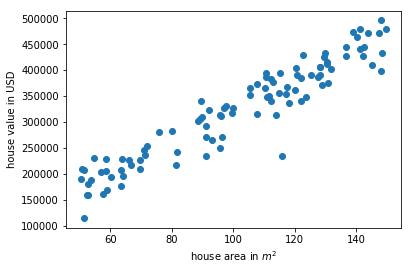

In [3]:
plt.scatter(d.area, d.value)
plt.xlabel("house area in $m^2$")
plt.ylabel("house value in USD")

## Linear regression setup

- $x_1^{(i)}$: area of house $i$
- $y^{(i)}$: value of house $i$
- $\hat{y}^{(i)}$: our estimate for the value of house $i$

**WE ASSUME** that the relation between the area and  value of a certain house is linear, so that our estimate is:

$$\hat{y}^{(i)} = \theta_0 + \theta_1 x_1^{(i)}$$

if we set $x_0^{(i)}=1$ for all $i$, the we can write the above expression more compactly in vector form, with $\theta = [\theta_0, \theta_1]$ y $\mathbf{x}=[x_0, x_1]$

$$\hat{y}^{(i)} = \theta\mathbf{x}^{(i)}$$

Given a set of $\theta$, and data for $n$ houses for which we know the actual value $y^{(i)}$, the total quadratic error of our estimate is

$$ J(\theta) = \frac{1}{m} \sum_{i=0}^{m-1} (\hat{y}^{(i)}-y^{(i)})^2 = \frac{1}{m} \sum_{i=0}^{,-1} (\mathbf{x}\theta^{(i)}-y^{(i)})^2$$


We now want to find the values $\theta_{min}$ that minimize this average error:


$$\theta_{min} = \underset{\theta}{arg\,min} \,\,\,J(\theta)$$ 

en modo matricial

$$J(\theta) = \text{mean}(\mathbf{X}\theta-\mathbf{y})^2$$

Where `mean` represents the mean of all elements of a vector.

For instance, the parameters $\theta_0=0$, $\theta_1=3800$ define predictions which can clearly miprove with respect to the data we have. Observe how we create the matrices $X$ e $y$, adding a column of 1's to $X$.

(100, 2) (100,)


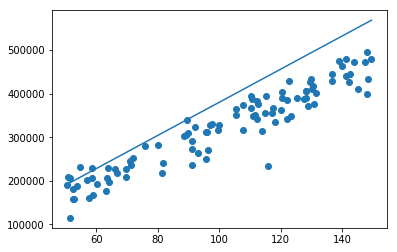

In [4]:
X = np.hstack((np.ones((len(d),1)), d[["area"]].as_matrix()))
y = d.value.as_matrix()
print X.shape, y.shape

t = np.array([0,3800])

xg = np.vstack((np.ones(100), np.linspace(np.min(d.area), np.max(d.area),100))).T
plt.scatter(d.area, d.value)
plt.plot(xg[:,1], xg.dot(t))

Observe how the cost function $J$ varies as we vary the parameters. Just by glancing this graph you can guess the value of the optimal params. This is because this problem is very simple and is **convex**. This will not be the case in general.

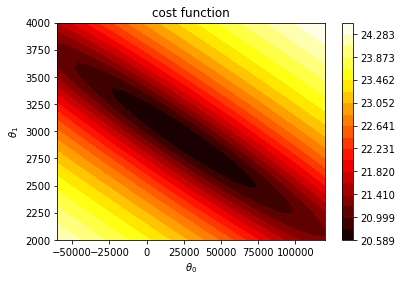

In [5]:
import itertools

def cost(t):
    return np.mean((X.dot(t)-y)**2)
    
def plot_cost(cost, t1_range, t2_range):
    k1,k2 = 40,40

    t1 = np.linspace(t1_range[0], t1_range[1], k1)
    t2 = np.linspace(t2_range[0], t2_range[1], k2)

    p = np.zeros((k1,k2))

    for i,j in itertools.product(range(k1), range(k2)):
        p[i,j] = np.log(cost(np.r_[t1[i],t2[j]]))

    plt.contourf(t1, t2, p.T, cmap=plt.cm.hot, levels=np.linspace(np.min(p), np.max(p), 20))
    plt.ylabel(r"$\theta_1$")
    plt.xlabel(r"$\theta_0$")
    plt.title("cost function")
    plt.colorbar()
    
plot_cost(cost, (-60000,120000), (2000,4000))


## Black box minimization

Una primera aproximación para obtener la recta con los parámetros $\theta_{min}$ según definido anteriormente es usando optimización sobre la función de coste $J$ como si fuera una _caja negra_. 

In the minimizer result `x` represents the parameters we want to find: $\theta_{min}$

In [6]:
r = minimize(cost, [0,0], method="BFGS")
print r

      fun: 871738162.9749104
 hess_inv: array([[  6.26703681e+00,  -5.67934212e-02],
       [ -5.67934212e-02,   5.58203232e-04]])
      jac: array([ 0.,  0.])
  message: 'Optimization terminated successfully.'
     nfev: 112
      nit: 9
     njev: 28
   status: 0
  success: True
        x: array([ 24739.09778868,   2937.33687009])


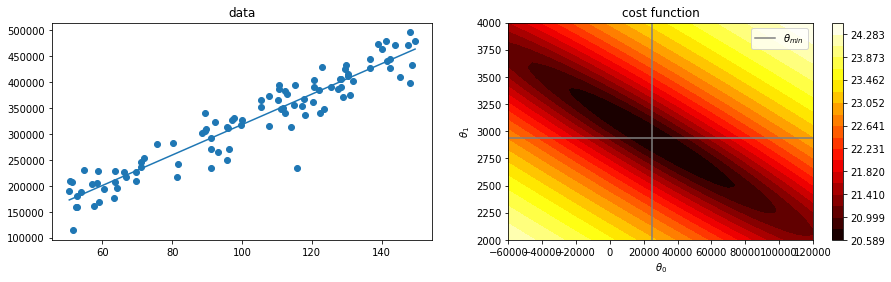

In [7]:
plt.figure(figsize=(15,4))
plt.subplot(121)
t = r.x
xg = np.vstack((np.ones(100), np.linspace(np.min(X[:,1]), np.max(X[:,1]),100))).T
plt.scatter(X[:,1], y)
plt.plot(xg[:,1], xg.dot(t))
plt.title("data")
plt.subplot(122)
plot_cost(cost, (-60000,120000), (2000,4000))
plt.axhline(r.x[1], color="gray", label=r"$\theta_{min}$")
plt.axvline(r.x[0], color="gray")
plt.legend()

El error de predicción medio que tenemos es de:

In [8]:
cost(r.x)

871738162.97491038

## Helping black box optimization by manually computing the gradient

The gradient of $J$ is

$$\nabla J = \begin{bmatrix}
\frac{\partial J}{\partial \theta_0}\\
\frac{\partial J}{\partial \theta_1}
\end{bmatrix} = \frac{1}{m}2X^{T}\cdot(X\cdot\theta-Y)$$

and this can computationally help the minimization algorithm. Observe that:

- the result `x` is the same but the number of evaluations is much lower.
- we needed to add a multiplicative constant to avoid numerical issues in the optimization algorithm

even in this small problem we start to find issues with generic tools. In machine learning we will need to develop specific algorithms and methods.

In [9]:
def grad(t):
    return 2*X.T.dot(X.dot(t)-y)/len(X)

In [10]:
r = minimize(cost, [0,0], jac=grad, method="BFGS")
print r

      fun: 871737913.4697466
 hess_inv: array([[  6.23113283e+00,  -5.64148414e-02],
       [ -5.64148414e-02,   5.55323776e-04]])
      jac: array([ -5.82076609e-12,  -9.12696123e-10])
  message: 'Optimization terminated successfully.'
     nfev: 14
      nit: 9
     njev: 14
   status: 0
  success: True
        x: array([ 24794.85968752,   2936.83230103])


moreover, observe that the gradient at the resulting $\theta$ is zero.

In [11]:
grad(r.x), cost(r.x)

(array([ -5.82076609e-12,  -9.12696123e-10]), 871737913.46974659)

## Implementing a gradient descent

This is one of the most basic optimization algorithms. We will scale $X$ so that we do not run into numerical problems

In [12]:
xk =  X.max(axis=0)
Xn = X/xk

def n_cost(t):
    return np.mean((Xn.dot(t)-y)**2)

def n_grad(t):
    return 2*Xn.T.dot(Xn.dot(t)-y)/len(Xn)


observe the gradient descent loop. we are using a **variable learning rate** as the different scales for $X$ and $y$ pose numerical issues.

In [13]:
t = np.r_[np.random.random()*50000, (np.random.random()*1e6)]
t_hist = [t.copy()]

for i in range(500):
    g = n_grad(t)
    t -= i/1000.*g
    t_hist.append(t.copy())
    
t_hist = np.r_[t_hist]/xk
print "theta start point ", t_hist[0]
print "theta end point   ", t_hist[-1]

theta start point  [ 31071.81687735   4954.04384288]
theta end point    [ 24650.50761591   2938.21445037]


we plot the descent

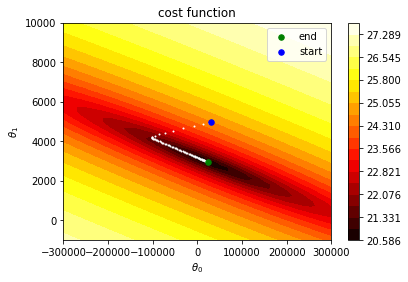

In [14]:
plot_cost(cost, (-300000,300000), (-1000,10000))
for t in t_hist[np.arange(0,len(t_hist),5)]:
    plt.scatter(t[0], t[1], s=1, color="white")
plt.scatter(t_hist[-1][0], t_hist[-1][1], s=30, c="green", label="end")
plt.scatter(t_hist[0][0], t_hist[0][1], s=30, c="blue", label="start")
plt.legend()

## Obtaining the gradient symbolically

Since this problem is small, we can use `sympy` to derive the gradient expression.

In [15]:
import sympy
sympy.init_printing(use_latex=True)

In [16]:
t0,t1 = sympy.symbols("theta_0 theta_1")
t0,t1

we build the expression with a small number of data points. Observe how `sympy` simplifies it

In [17]:
expr = 0
for i in range(10):
    expr += (X[i,0]*t0+X[i,1]*t1-y[i])**2 / len(X)
expr = expr
expr

In [18]:
print y[:10]
X[:10]

[202970 312626 264921 272091 209846 317444 161472 478948 241927 350402]


array([[   1.  ,   57.02],
       [   1.  ,   96.07],
       [   1.  ,   93.18],
       [   1.  ,   91.05],
       [   1.  ,   69.76],
       [   1.  ,   99.59],
       [   1.  ,   57.62],
       [   1.  ,  149.57],
       [   1.  ,   81.67],
       [   1.  ,  111.62]])

In [19]:
expr = expr.simplify()
expr

so we build and simplify the cost expression for all data points.

In [20]:
expr_cost = 0
for i in range(len(X)):
    expr_cost += (X[i,0]*t0+X[i,1]*t1-y[i])**2 / len(X)
expr_cost = expr_cost.simplify()
expr_cost

obtain the gradient expressions

In [21]:
expr_dt0 = expr_cost.diff(t0)
expr_dt1 = expr_cost.diff(t1)
expr_dt0, expr_dt1

observe they correspond to what we obtained above.

In [22]:
th = np.r_[24700, 2900]

def e_grad(x):
    return np.r_[float(expr_dt0.subs({t0: x[0], t1: x[1]})), float(expr_dt1.subs({t0: x[0], t1: x[1]}))]

print "numerical gradient   ", grad(th)
print "symbolic substitution", e_grad(th)

numerical gradient    [  -7673.24   -845843.3408]
symbolic substitution [  -7673.24       -845843.34079996]


however, evaluating the gradient from the expressions is very expensive computationally

In [23]:
%timeit grad(th)

The slowest run took 8.30 times longer than the fastest. This could mean that an intermediate result is being cached.
100000 loops, best of 3: 7.24 µs per loop


In [24]:
%timeit e_grad(th)

The slowest run took 7.55 times longer than the fastest. This could mean that an intermediate result is being cached.
1000 loops, best of 3: 498 µs per loop


fortunately, symbolic expressions can  be converted into regular Python functions. Observe we create functions for **BOTH** the cost and its gradient.

In [25]:
s_cost = sympy.lambdify([[t0,t1]], expr_cost, "numpy")

d0 = sympy.lambdify([[t0,t1]], expr_dt0, "numpy")
d1 = sympy.lambdify([[t0,t1]], expr_dt1, "numpy")
s_grad = lambda x: np.array([d0(x), d1(x)])
print "generated python function for cost:    ", s_cost(th)
print "generated python function for gradient:", s_grad(th)

generated python function for cost:     887679032.32
generated python function for gradient: [  -7673.24   -845843.3408]


In [26]:
%timeit s_grad(th) 

10000 loops, best of 3: 30.8 µs per loop


and now we can use them in the minimizer

In [27]:
r = minimize(s_cost, [0,0], jac=s_grad, method="BFGS")
print r

      fun: 871737913.4697323
 hess_inv: array([[  6.23113283e+00,  -5.64148414e-02],
       [ -5.64148414e-02,   5.55323776e-04]])
      jac: array([  1.16415322e-10,   7.45058060e-09])
  message: 'Optimization terminated successfully.'
     nfev: 14
      nit: 9
     njev: 14
   status: 0
  success: True
        x: array([ 24794.85968753,   2936.83230103])


all functions are the same. in the cost function, there is a constant difference as we defined it

In [28]:
t = np.array([np.random.random()*5000+20000, np.random.random()*1000+20000])
print "theta:",t
print "cost analytic:", cost(t)
print "cost symbolic:", s_cost(t)

print "gradient analytic:", grad(t)
print "gradient symbolic:", s_grad(t)

theta: [ 21672.80230964  20131.72663596]
cost analytic: 3.30754171374e+12
cost symbolic: 3.30754171374e+12
gradient analytic: [  3.48738357e+06   3.85243877e+08]
gradient symbolic: [  3.48738357e+06   3.85243877e+08]
